# Multivariate regression to predict the wind speed field

In [13]:
import torch
import torch.nn as nn
import numpy as np

from utils.data_loaders import get_wake_dataloaders
import utils.utils as utils
import utils.data_utils as data_utils 
from utils.metrics import MetricsLogger, RMSELoss
import utils.plotting as plotting

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [14]:
HIDDEN_LAYERS_UNITS = [50, 500]

class MultivariateNN(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(MultivariateNN, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS + [output_space]
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), nn.ReLU()]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [15]:
FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"multivariate_NN_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = False
COORDS_AS_INPUT = False # multivariate setting
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
    print(MODEL_NAME)
    print(BEST_MODEL_PATH)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

# hyperparameters
BATCH_SIZE = 8
EPOCHS = 500
LR = 0.0001

DEVICE=device(type='cpu')


In [16]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader)

KeyboardInterrupt: 

In [ ]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.x.shape[1]
output_space = train_dataloader.dataset.y.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([8, 3]) torch.Size([8, 7168])
input_space=3	output_space=7168


Logging multivariate_NN_layers50-500_consider_ws
Epoch 0 ->	Training loss (MSE)=0.000640883796964772	Training RMSE=0.02391111922264099	Validation loss (MSE)=0.00047831031439603646	Validation RMSE=0.018194798126139423	
Epoch 1 ->	Training loss (MSE)=0.0004413239249314012	Training RMSE=0.02015023510022597	Validation loss (MSE)=0.0004178185838276422	Validation RMSE=0.016752271280821525	
Epoch 2 ->	Training loss (MSE)=0.00039346048214197667	Training RMSE=0.019066752538084982	Validation loss (MSE)=0.0003814351402318359	Validation RMSE=0.015951919009288152	
Epoch 3 ->	Training loss (MSE)=0.00037257883379722694	Training RMSE=0.018540480915795673	Validation loss (MSE)=0.0003663043858052168	Validation RMSE=0.01554825243060336	
Epoch 4 ->	Training loss (MSE)=0.00036133971815632484	Training RMSE=0.018246852724389598	Validation loss (MSE)=0.0003569910168020711	Validation RMSE=0.015313366637988523	
Epoch 5 ->	Training loss (MSE)=0.0003519876821400513	Training RMSE=0.01796587764945897	Validation los

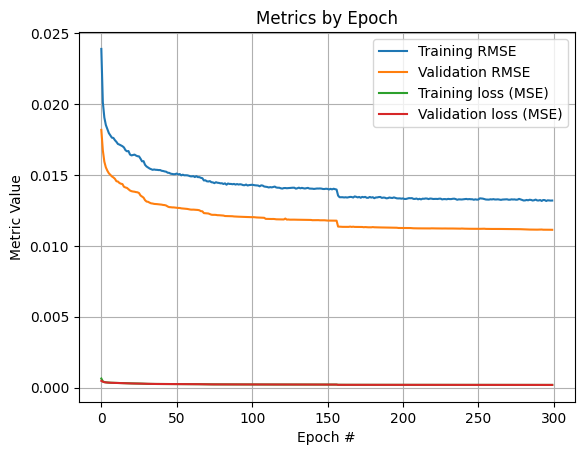

Metrics exported in the following csv file: logged_metrics/multivariateNNlayers50-500considerws_29-05-2023_11-18-56.csv


In [ ]:
model = MultivariateNN(input_space, output_space).to(DEVICE)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)

loss_function = torch.nn.MSELoss()
rmse_function = RMSELoss()

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_v_loss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    model.train(True)
    epoch_t_loss = 0
    epoch_t_rmse = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()
        prediction = model.forward(input_features)
        tloss = loss_function(prediction, wake_field)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_t_loss += tloss.item() * input_features.size(0)

        # other metrics
        rmse = rmse_function(prediction, wake_field)
        epoch_t_rmse += rmse.item() * input_features.size(0)

    avg_t_loss = epoch_t_loss / len(train_dataloader.sampler)
    avg_t_rmse = epoch_t_rmse / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss (MSE)', avg_t_loss)
    metrics_logger.log_metric(epoch, 'Training RMSE', avg_t_rmse)

    '''VALIDATION'''
    if valid_dataloader:
        model.train(False)
        epoch_v_loss = 0
        epoch_v_rmse = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
            prediction = model(input_features)
            vloss = loss_function(prediction, wake_field)

            epoch_v_loss += vloss.item() * input_features.size(0)
            rmse = rmse_function(prediction, wake_field)
            epoch_v_rmse += rmse.item() * input_features.size(0)

        avg_v_loss = epoch_v_loss / len(valid_dataloader.sampler)
        avg_v_rmse = epoch_v_rmse / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss (MSE)', avg_v_loss)
        metrics_logger.log_metric(epoch, 'Validation RMSE', avg_v_rmse)
        # Track best performance, and save the model's state
        if avg_v_loss < best_v_loss:
            best_vloss = avg_v_loss
            torch.save(model.state_dict(), BEST_MODEL_PATH)

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

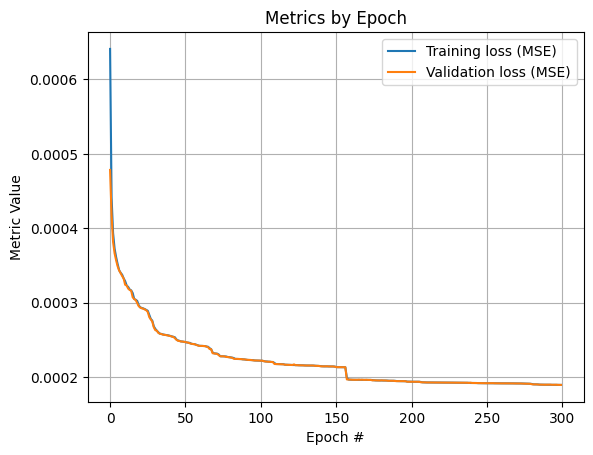

In [ ]:
metrics_logger.plot_metrics_by_epoch(["Training loss (MSE)", "Validation loss (MSE)"])

# Testing

In [ ]:
# loading best model
model = MultivariateNN(input_space, output_space).to(DEVICE)
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()
loss_function = torch.nn.MSELoss()

total_loss = 0
total_deficit = 0
with torch.no_grad():
    for batch in iter(test_dataloader):
        # to device
        x, y = batch[0].to(DEVICE), batch[1].to(DEVICE)

        prediction = model(x)
        tloss = loss_function(prediction, y)

        total_loss += tloss.item()*x.size(0)
        total_deficit += y.mean(1).sum()

avg_loss = total_loss / len(test_dataloader.sampler)
avg_deficit = total_deficit / len(test_dataloader.sampler)
print(f"Testing results: avg loss={avg_loss} on an avg deficit per wake of {avg_deficit}")

Testing results: avg loss=0.00018952359328206072 on an avg deficit per wake of 0.01995871029794216


max_deficit=tensor(0.0526)


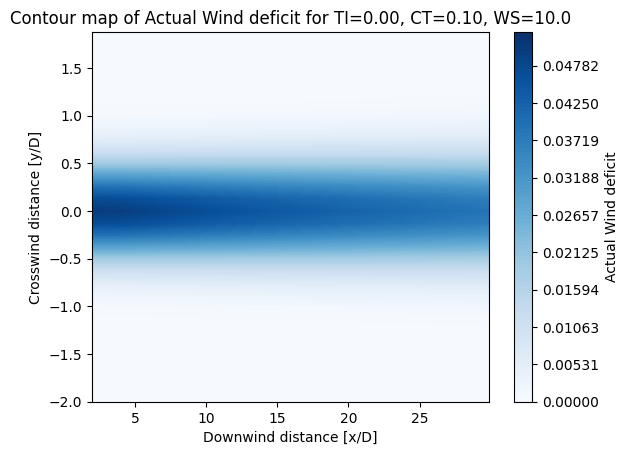

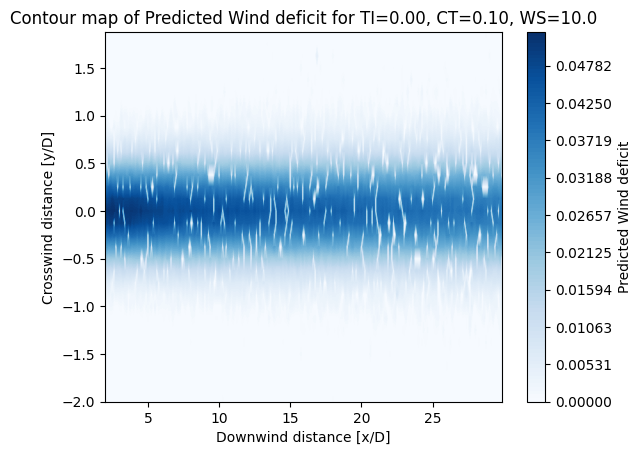

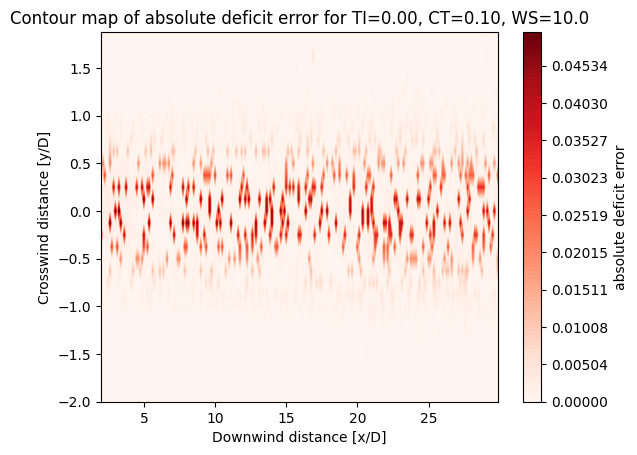

max_deficit=tensor(0.0510)


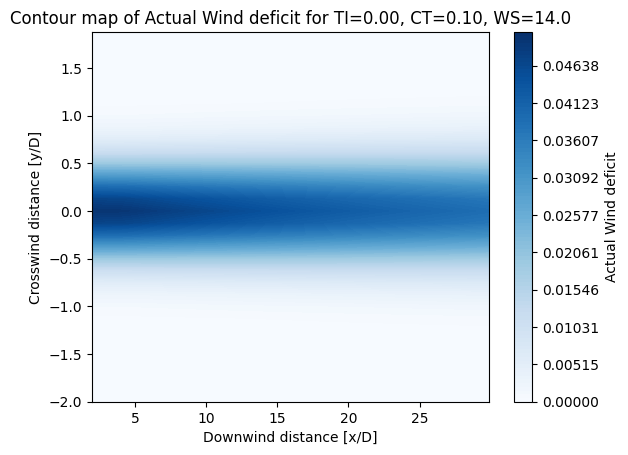

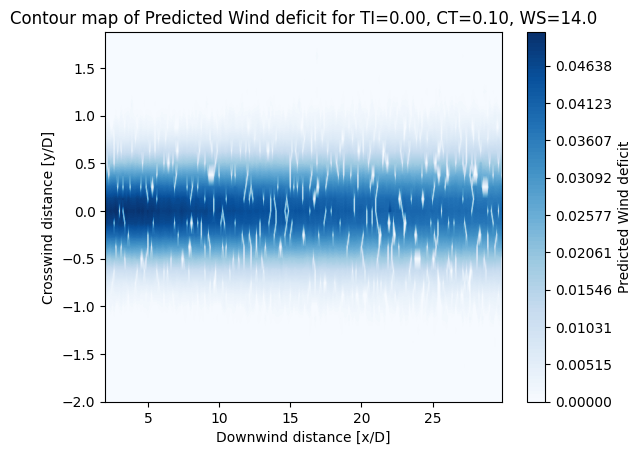

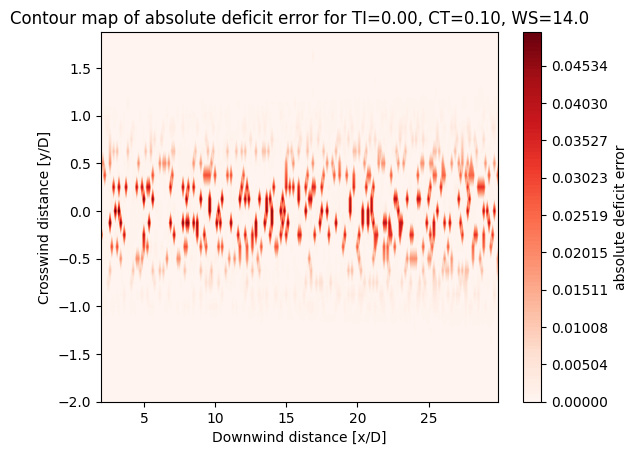

max_deficit=tensor(0.0510)


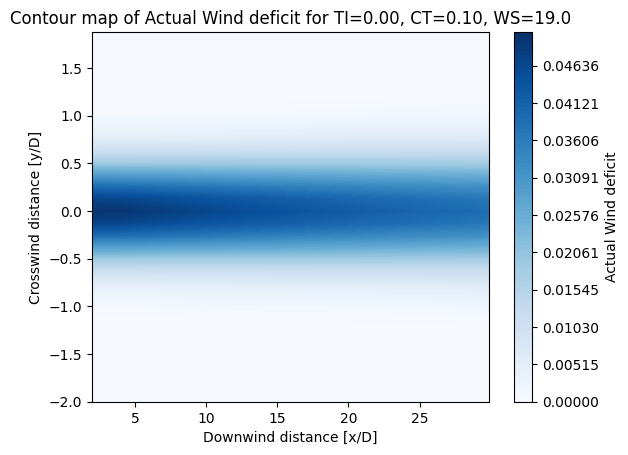

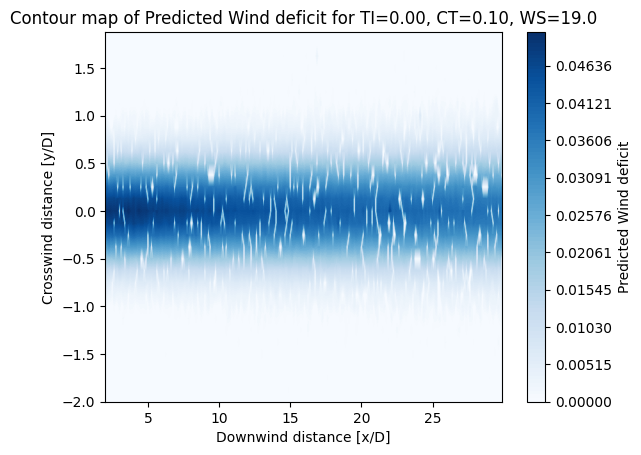

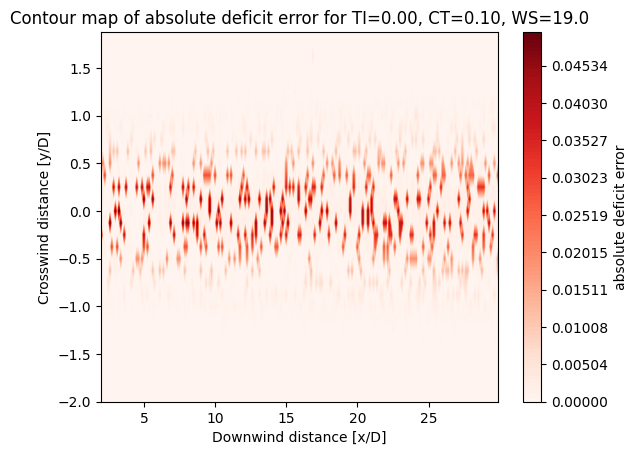

max_deficit=tensor(0.0903)


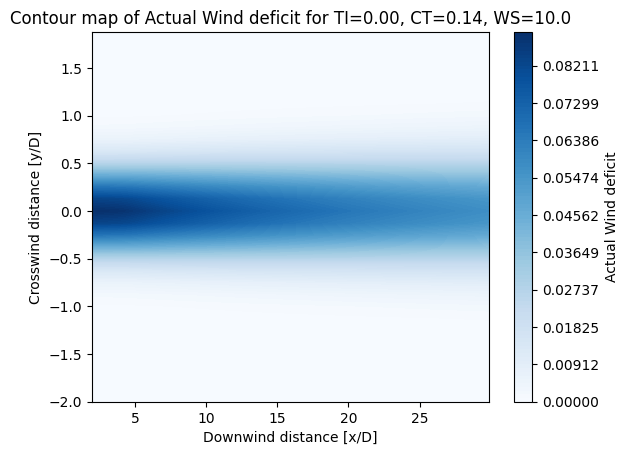

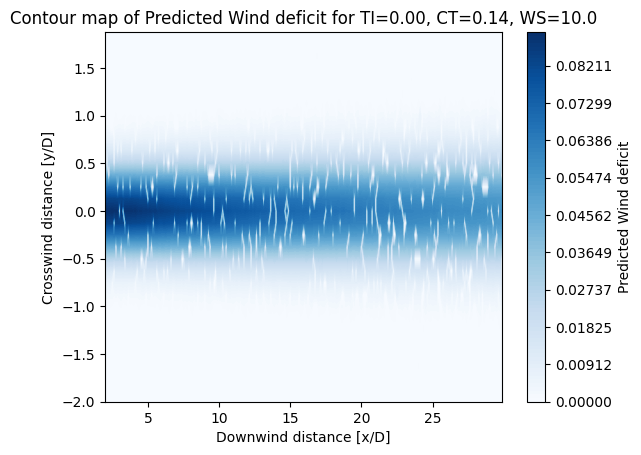

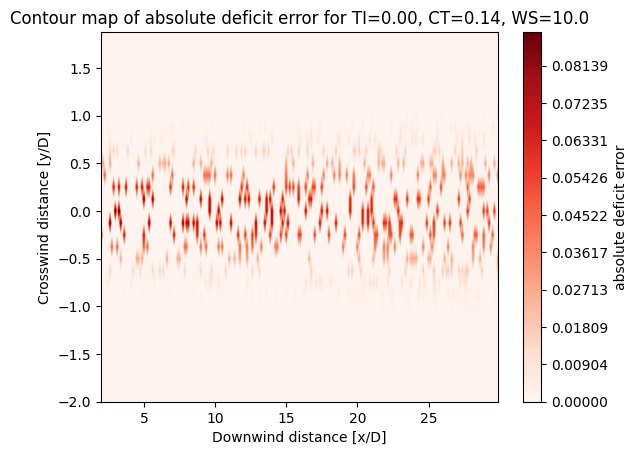

max_deficit=tensor(0.0904)


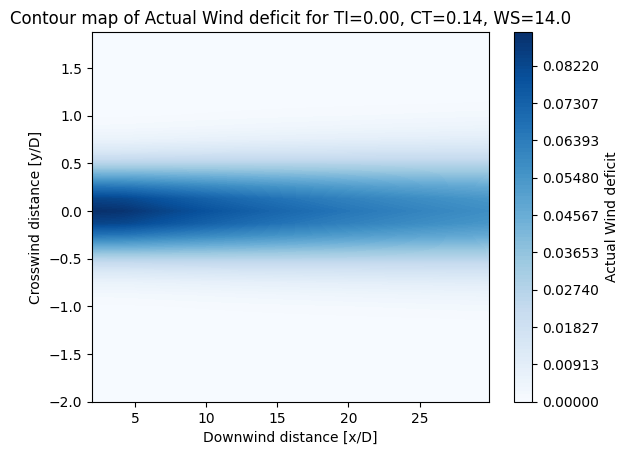

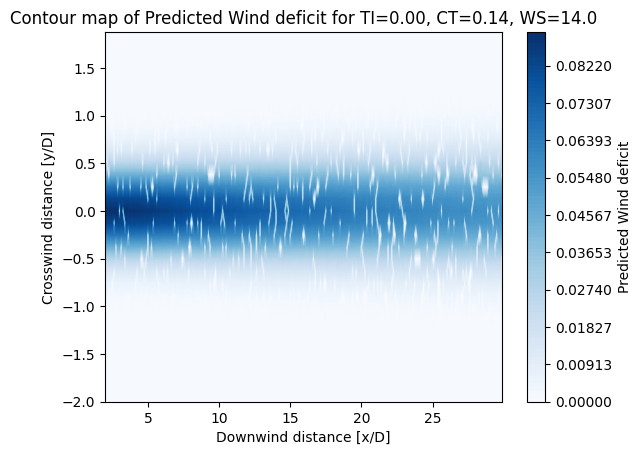

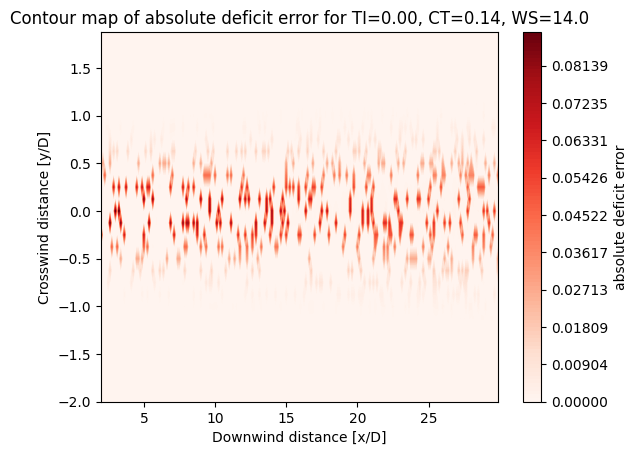

max_deficit=tensor(0.0916)


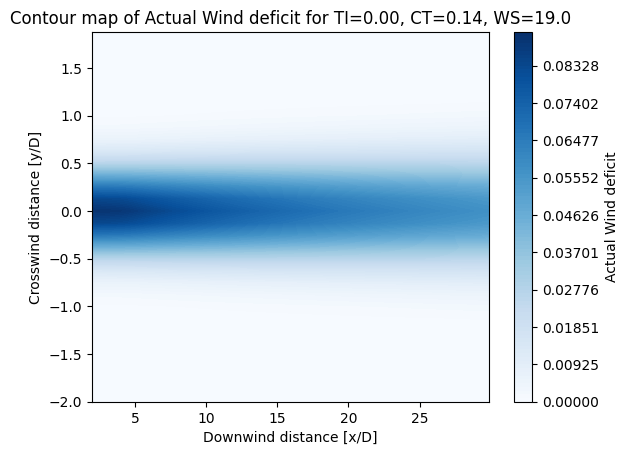

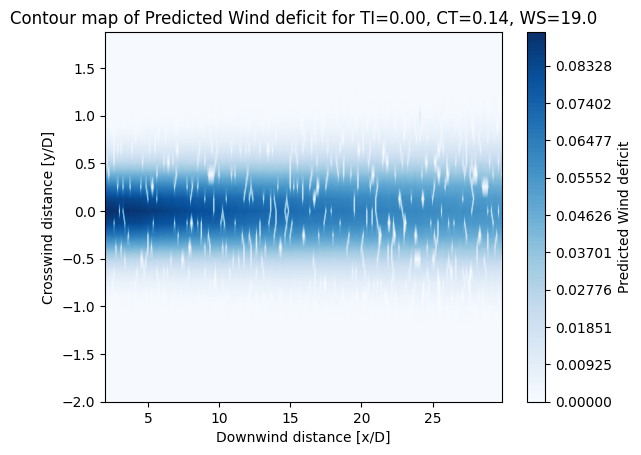

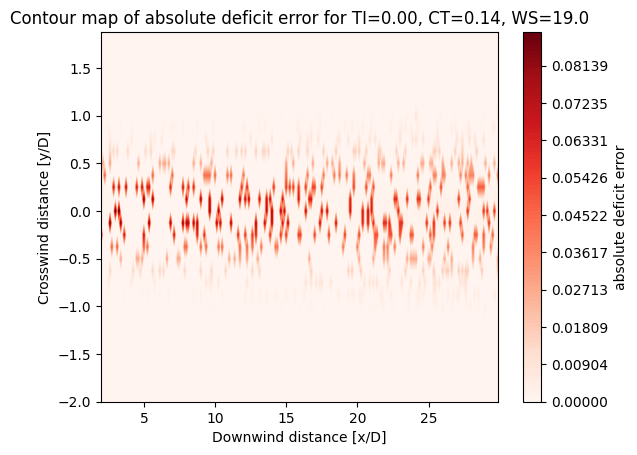

max_deficit=tensor(0.1304)


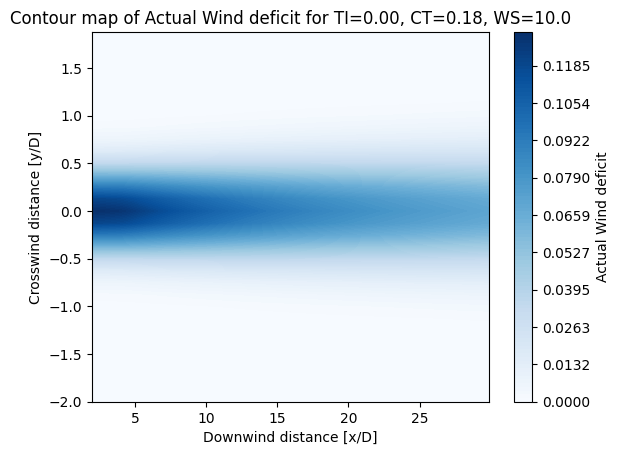

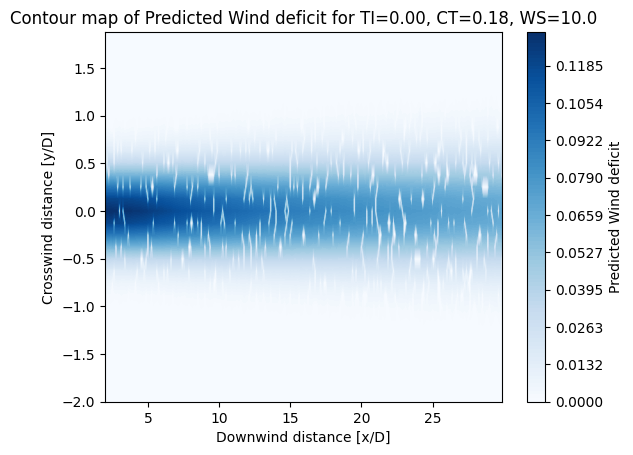

KeyboardInterrupt: 

In [ ]:
X, Y = np.meshgrid(*utils.get_wake_coordinates_from_discr_factors(*data_utils.get_parameters_from(DATA_FOLDER)[:5]))

if CONSIDER_WS:
    with torch.no_grad():
        for idx, (input, wake_field) in enumerate(test_dataloader.dataset):
            predicted_wake_field = model(input)
            
            ti, ct, ws = test_dataloader.dataset.unscaled_x[idx]

            plotting.plot_maps(X, Y, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')
else:
    with torch.no_grad():
        for batch in iter(test_dataloader):
            inputs, targets = batch

            for input, wake_field in zip(inputs, targets):
                predicted_wake_field = model(input)
                ti, ct = input
                ws = None
                
                plotting.plot_maps(X, Y, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')
        
